In [2]:
#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential, Model
from keras.regularizers import l2  
# Utils
import os
import cv2
from sklearn.utils import shuffle
from pathlib import Path
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time

#Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

# #mount drive
# from google.colab import drive

# Core
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns;
from glob import glob 
import random

In [1]:
def img_Generator(file_name,gen_type,width, length):
    if gen_type=='yes':
        generet_Data=ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
        gen_data=generet_Data.flow_from_directory(file_name,target_size=(width, length),
                                                  batch_size=32,shuffle=True,
                                                  class_mode='categorical')
                
    else:
        generet_Data1=ImageDataGenerator()
        gen_data=generet_Data1.flow_from_directory(file_name,target_size=(width, length),
                                                  batch_size=32,shuffle=False,
                                                  class_mode='categorical')
    
    return gen_data

In [3]:
import pandas as pd
import matplotlib.pyplot  as plt
from PIL import Image
from pathlib import Path
import imagesize
import numpy as np
root='C:/Users/Hanif/Documents/Kuliah/TA/Data/Original/'
img_met_fin = []
img_meta_df = pd.DataFrame()
dataframe_collection={}
imgs={}

for i,labels in enumerate(os.listdir(root)):
    # Get the Image Resolutions
    imgs[i] = [img.name for img in Path(root+labels).iterdir() if img.suffix == ".jpg"]
    img_meta = {}
    for f in imgs[i]: img_meta[str(f)] = imagesize.get(root+labels+'/'+f)
#     img_met_fin+=img_meta
    dataframe_collection[i] = pd.DataFrame.from_dict([img_meta]).T.reset_index().set_axis(['FileName', 'Size'], axis='columns', inplace=False)
    dataframe_collection[i][["Width", "Height"]] = pd.DataFrame(dataframe_collection[i]["Size"].tolist(), index=dataframe_collection[i].index)
    dataframe_collection[i]["Aspect Ratio"] = round(dataframe_collection[i]["Width"] / dataframe_collection[i]["Height"], 2)

frames = [dataframe_collection[i] for i in range(len(dataframe_collection))]
result = pd.concat(frames)

# print(f'Total Nr of Images in the dataset: {len(img_meta_df)}')
print(result)
# print(img_meta)

         FileName        Size  Width  Height  Aspect Ratio
0     pic_001.jpg  (225, 225)    225     225          1.00
1     pic_002.jpg  (318, 159)    318     159          2.00
2     pic_003.jpg  (194, 259)    194     259          0.75
3     pic_004.jpg  (217, 232)    217     232          0.94
4     pic_005.jpg  (273, 184)    273     184          1.48
..            ...         ...    ...     ...           ...
717  soto_719.jpg  (331, 152)    331     152          2.18
718  soto_720.jpg  (268, 188)    268     188          1.43
719  soto_721.jpg  (192, 263)    192     263          0.73
720  soto_722.jpg  (310, 163)    310     163          1.90
721  soto_723.jpg  (310, 163)    310     163          1.90

[5011 rows x 5 columns]


In [4]:
result.describe()

,Width,Height,Aspect Ratio
count,5011.000000,5011.000000,5011.000000
mean,261.215127,195.906007,1.391397
std,38.694510,31.473439,0.380370
min,128.000000,94.000000,0.440000
25%,225.000000,168.000000,1.000000
50%,275.000000,183.000000,1.500000
75%,299.000000,225.000000,1.770000
max,440.000000,339.000000,3.860000


Text(0, 0.5, 'Height')

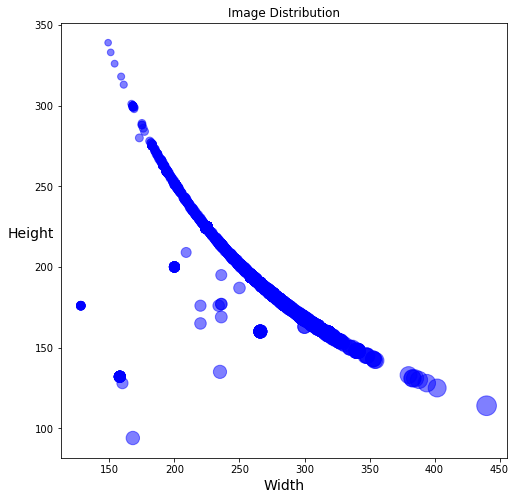

In [5]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
points = ax.scatter(result.Width, result.Height, color='blue', alpha=0.5, s=result["Aspect Ratio"]*100, picker=True)
ax.set_title("Image Distribution")
ax.set_xlabel("Width", size=14)
ax.set_ylabel("Height", size=14,rotation=0)

In [3]:
#CNN
CNN_width=261
CNN_height=195
image_path='C:/Users/Hanif/Documents/Kuliah/TA/Data/0_3_Split'
data_typ='yes'
train_data=img_Generator(str(image_path)+'/train/',data_typ,CNN_width,CNN_height)
data_typ='no'
test_data=img_Generator(str(image_path)+'/test/',data_typ,CNN_width,CNN_height)

Found 2866 images belonging to 10 classes.
Found 1193 images belonging to 10 classes.


In [9]:
train_data

In [22]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction]

In [8]:
cnn_model = Sequential()
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(100,(5,5), kernel_regularizer=l2(0.00005),padding ='Same',activation = 'relu',input_shape=(CNN_width,CNN_height,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(64,(5,5) ,kernel_regularizer=l2(0.00005),padding ='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(64,(3,3),kernel_regularizer=l2(0.00005),padding ='same',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(10, activation ='softmax'))
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 261, 195, 100)     7600      
                                                                 
 batch_normalization (BatchN  (None, 261, 195, 100)    400       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 130, 97, 100)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 130, 97, 64)       160064    
                                                                 
 batch_normalization_1 (Batc  (None, 130, 97, 64)      256       
 hNormalization)                                                 
                                                      

In [9]:
cnn_model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
batch_size = 32
# Training model

n_training_samples = len(train_data)
t0 = time.time()
cnn_history = cnn_model.fit(
    train_data,
    epochs=200,
    # steps_per_epoch =(n_training_samples//batch_size)*2,
    shuffle = True,
    callbacks=callbacks_list
    )
record_time =time.time()-t0
print("Training time:", record_time)


Epoch 1/200
92/92 [==============================] - 668s 7s/step - loss: 2.7318 - accuracy: 0.1432 - lr: 0.0010
Epoch 2/200
92/92 [==============================] - 656s 7s/step - loss: 2.4198 - accuracy: 0.1788 - lr: 0.0010
Epoch 3/200
92/92 [==============================] - 656s 7s/step - loss: 2.2535 - accuracy: 0.1949 - lr: 0.0010
Epoch 4/200
92/92 [==============================] - 657s 7s/step - loss: 2.1280 - accuracy: 0.2281 - lr: 0.0010
Epoch 5/200
92/92 [==============================] - 656s 7s/step - loss: 2.0343 - accuracy: 0.2616 - lr: 0.0010
Epoch 6/200
92/92 [==============================] - 657s 7s/step - loss: 2.0060 - accuracy: 0.2716 - lr: 0.0010
Epoch 7/200
92/92 [==============================] - 656s 7s/step - loss: 1.9574 - accuracy: 0.2911 - lr: 0.0010
Epoch 8/200
92/92 [==============================] - 657s 7s/step - loss: 1.9073 - accuracy: 0.3062 - lr: 0.0010
Epoch 9/200
92/92 [==============================] - 666s 7s/step - loss: 1.8777 - accuracy: 0.3

In [11]:
from keras.models import Model
#save the model
cnn_model.save('C:/Users/Hanif/Documents/Kuliah/TA/Models/CNN/CNN_RMSPROP')

INFO:tensorflow:Assets written to: C:/Users/Hanif/Documents/Kuliah/TA/Models/CNN/CNN_RMSPROP\assets


INFO:tensorflow:Assets written to: C:/Users/Hanif/Documents/Kuliah/TA/Models/CNN/CNN_RMSPROP\assets


In [5]:
from keras.models import Model
cnn_model = tf.keras.models.load_model('C:/Users/Hanif/Documents/Kuliah/TA/Models/CNN/CNN_RMSPROP')

In [19]:
cnn_model.metrics_names

['loss', 'accuracy']

In [12]:
cnn_model.evaluate(test_data)

40/40 [==============================] - 44s 1s/step - loss: 1.1133 - accuracy: 0.6425


[1.11331307888031, 0.6425158977508545]

38/38 [==============================] - 84s 2s/step


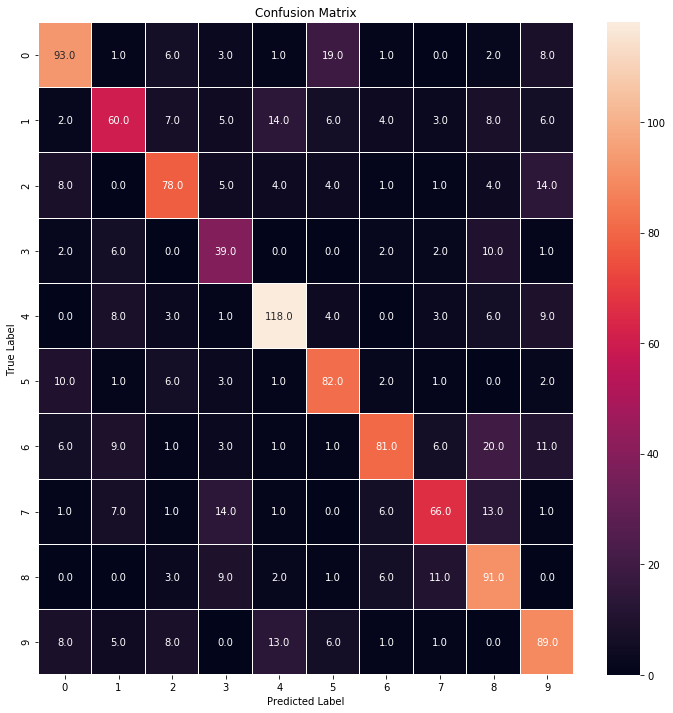

In [6]:
y_val = test_data.classes
y_pred = cnn_model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_val)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# ax.xaxis.set_ticklabels(test_data.class_indices)
# ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [7]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, y_val)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_pred, y_val, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_pred, y_val, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, y_val, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.668064
Precision: 0.663086
Recall: 0.663780
F1 score: 0.658853
